In [1]:
!unzip flowers.zip
%ls

Archive:  flowers.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: test/daisy/10466290366_cc72e33532_jpg.rf.6ddc91cd5d4a6a683e567ccb37e5a089.jpg  
  inflating: test/daisy/10466558316_a7198b87e2_jpg.rf.7acf642b94dc98daa49482a12994ac4c.jpg  
  inflating: test/daisy/12193032636_b50ae7db35_n_jpg.rf.e6c4eeb71c56e793a0d85f6d979dbe20.jpg  
  inflating: test/daisy/1342002397_9503c97b49_jpg.rf.8fe6bdd23186b70f089bb0c5b89d314e.jpg  
  inflating: test/daisy/1354396826_2868631432_m_jpg.rf.409eee37613d16dbc71365cb5615327e.jpg  
  inflating: test/daisy/1374193928_a52320eafa_jpg.rf.e398f632151f3ccc5729bc89527d7614.jpg  
  inflating: test/daisy/1392131677_116ec04751_jpg.rf.da99f9bb579ee96dc1728545ca519d6f.jpg  
  inflating: test/daisy/14333681205_a07c9f1752_m_jpg.rf.6ff96d9fe33f0bd19a18425f32d470b1.jpg  
  inflating: test/daisy/14399435971_ea5868c792_jpg.rf.89b733453e10d461d440acc99b7ef6d1.jpg  
  inflating: test/daisy/14564545365_1f1d267bf1_n_jpg.rf.b848a44

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [6]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
# Define the data directory
data_dir = 'sample_data'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
#image_datasets

In [10]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 1275, 'valid': 364}


['daisy', 'dandelion']

In [11]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


In [13]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 0.5848 Acc: 0.7733
valid Loss: 0.2233 Acc: 0.9121
train Loss: 0.4913 Acc: 0.7922
valid Loss: 0.1710 Acc: 0.9396
train Loss: 0.5013 Acc: 0.7969
valid Loss: 0.2326 Acc: 0.9231
train Loss: 0.5221 Acc: 0.7937
valid Loss: 0.2199 Acc: 0.9066
train Loss: 0.4317 Acc: 0.8227
valid Loss: 0.1859 Acc: 0.9231
train Loss: 0.4370 Acc: 0.8149
valid Loss: 0.2580 Acc: 0.8956
train Loss: 0.4591 Acc: 0.8188
valid Loss: 0.3001 Acc: 0.8791
train Loss: 0.5333 Acc: 0.7976
valid Loss: 0.1701 Acc: 0.9231
train Loss: 0.4115 Acc: 0.8290
valid Loss: 0.1728 Acc: 0.9341
train Loss: 0.4948 Acc: 0.8094
valid Loss: 0.3134 Acc: 0.8874
Training complete!


In [14]:
# Save the model
torch.save(model.state_dict(), 'flower_classification_model.pth')

Classification on Unseen Image


To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference.

In [15]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('flower_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

<ipython-input-15-a75b56b3d7d2>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('flower_classification_model.pth'))


Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

In [16]:
# Load and preprocess the unseen image
image_path = 'test.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

Performance inference model

In [17]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['daisy', 'dandelion']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: dandelion


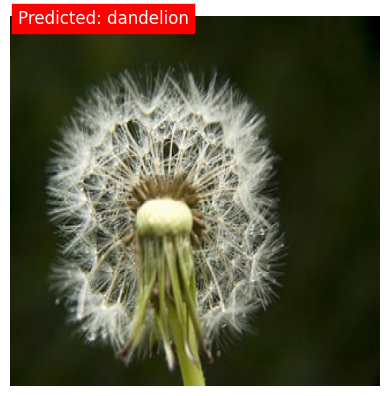

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()